# Personalized Marketing and Targeted Advertisng

**This notebook is divided into following sections:**
1. Importing data and required libraries
2. Data Cleaning
3. Segmentation
4. Data Modelling
5. Conclusion

# **1. Importing data and required libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/starbucks-customer-data/transcript.csv
/kaggle/input/starbucks-customer-data/profile.csv
/kaggle/input/starbucks-customer-data/portfolio.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
portfolio = pd.read_csv('../input/starbucks-customer-data/portfolio.csv')
profile = pd.read_csv('../input/starbucks-customer-data/profile.csv')
transcript = pd.read_csv('../input/starbucks-customer-data/transcript.csv')

In [4]:
portfolio.info()
profile.info()
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10 non-null     int64 
 1   reward      10 non-null     int64 
 2   channels    10 non-null     object
 3   difficulty  10 non-null     int64 
 4   duration    10 non-null     int64 
 5   offer_type  10 non-null     object
 6   id          10 non-null     object
dtypes: int64(4), object(3)
memory usage: 688.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        17000 non-null  int64  
 1   gender            14825 non-null  object 
 2   age               17000 non-null  int64  
 3   id                17000 non-null  object 
 4   became_member_on  17000 non-null  int64  
 5   income            14825 non-null  float64


# **2. Data Cleaning**

In [5]:
portfolio.isnull().sum()

Unnamed: 0    0
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
profile.isnull().sum()

Unnamed: 0             0
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [7]:
transcript.isnull().sum()

Unnamed: 0    0
person        0
event         0
value         0
time          0
dtype: int64

In [8]:
profile.drop('Unnamed: 0', axis=1, inplace=True)
transcript.drop('Unnamed: 0', axis=1, inplace=True)
portfolio.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
profile['gender'].fillna("O", inplace=True)

In [10]:
profile[profile['age']==118]['gender'].value_counts()

O    2175
Name: gender, dtype: int64

In [11]:
profile.drop(profile.index[(profile['age'] < 119) & (profile['age'] > 100)], inplace = True)
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [12]:
gender_profile = profile.gender.value_counts().reset_index()
gender_profile.columns = ['gender', 'count']
fig = px.pie(gender_profile, values='count', names='gender', title='Gender',
             color_discrete_sequence=['blue', 'light green'])
fig.show()

<AxesSubplot:xlabel='income'>

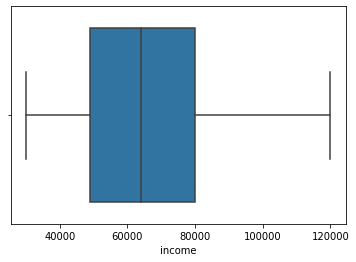

In [13]:
sns.boxplot(data=profile, x='income')

In [14]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
profile['became_member_on'].head()

1    2017-07-15
3    2017-05-09
5    2018-04-26
8    2018-02-09
12   2017-11-11
Name: became_member_on, dtype: datetime64[ns]

In [15]:
profile['year'] = profile['became_member_on'].dt.year
profile['month'] = profile['became_member_on'].dt.month
profile['day']=profile['became_member_on'].dt.day_name()
profile['membership_days'] = (pd.to_datetime('today') - profile['became_member_on']).astype('timedelta64[D]').astype(int)

Text(0, 0.5, 'income')

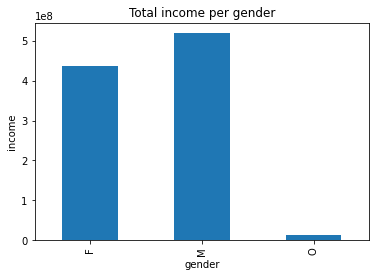

In [16]:
profile.groupby('gender').sum()['income'].plot(kind='bar')
plt.title('Total income per gender')
plt.ylabel('income')

In [17]:
profile['age_group'] = pd.cut(x=profile['age'], bins=[18, 20, 40, 60, 101],
                    labels=['Teenage(0-19)', 'Young(20-39)','Middle-age(40-59)',
                            'Old(60-100)'], include_lowest=True)
profile['age_group']

1        Middle-age(40-59)
3              Old(60-100)
5              Old(60-100)
8              Old(60-100)
12       Middle-age(40-59)
               ...        
16995    Middle-age(40-59)
16996          Old(60-100)
16997    Middle-age(40-59)
16998          Old(60-100)
16999          Old(60-100)
Name: age_group, Length: 14820, dtype: category
Categories (4, object): ['Teenage(0-19)' < 'Young(20-39)' < 'Middle-age(40-59)' < 'Old(60-100)']

In [18]:
from sklearn.preprocessing import LabelEncoder

profile = profile.copy(deep = True)
le_age = LabelEncoder()
profile['age_group'] = le_age.fit_transform(profile['age_group'])
profile.head(5)

,gender,age,id,became_member_on,income,year,month,day,membership_days,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,Saturday,1747,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,Tuesday,1814,1
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,Thursday,1462,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,Friday,1538,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,Saturday,1628,0


In [19]:
profile['income_group'] = pd.cut(x=profile['income'], bins=[30000, 50000, 75000, 100000, 120000],
                    labels=['30k-50k', '50k-75k','75k-1L',
                            'more than 1L'], include_lowest=True)
profile['income_group']

1        more than 1L
3              75k-1L
5             50k-75k
8             50k-75k
12            50k-75k
             ...     
16995         50k-75k
16996         50k-75k
16997         50k-75k
16998         30k-50k
16999          75k-1L
Name: income_group, Length: 14820, dtype: category
Categories (4, object): ['30k-50k' < '50k-75k' < '75k-1L' < 'more than 1L']

In [20]:
from sklearn.preprocessing import LabelEncoder

profile = profile.copy(deep = True)
le_in = LabelEncoder()
profile['income_group'] = le_in.fit_transform(profile['income_group'])
profile.head(5)

,gender,age,id,became_member_on,income,year,month,day,membership_days,age_group,income_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,Saturday,1747,0,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,Tuesday,1814,1,2
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,Thursday,1462,1,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,Friday,1538,1,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,Saturday,1628,0,1


In [21]:
profile = profile.drop(['age','income'], axis=1)

In [22]:
transcript['time_group'] = pd.cut(x=transcript['time'], bins=[0, 100, 200, 300, 400, 500,600,700,800], include_lowest=True,
                    labels=['0-100 days', '100-200 days', '200-300 days', '300-400 days', '400-500 days', '500-600 days', '600-700 days', '700-800 days'])
transcript['time_group'] 

0           0-100 days
1           0-100 days
2           0-100 days
3           0-100 days
4           0-100 days
              ...     
306529    700-800 days
306530    700-800 days
306531    700-800 days
306532    700-800 days
306533    700-800 days
Name: time_group, Length: 306534, dtype: category
Categories (8, object): ['0-100 days' < '100-200 days' < '200-300 days' < '300-400 days' < '400-500 days' < '500-600 days' < '600-700 days' < '700-800 days']

In [23]:
from sklearn.preprocessing import LabelEncoder

transcript = transcript.copy(deep = True)
le_id = LabelEncoder()
transcript['time_group'] = le_id.fit_transform(transcript['time_group'])
transcript.head(5)
transcript

,person,event,value,time,time_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,7
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,7
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,7
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,7


In [24]:
transcript = transcript.drop(['time'], axis=1)

In [25]:
transcript.rename(columns={'person':'id'}, inplace=True)

In [26]:
df = pd.merge(profile, transcript, on='id')
df = df.drop(['became_member_on'], axis=1)
df

,gender,id,year,month,day,membership_days,age_group,income_group,event,value,time_group
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,{'amount': 21.51},0
1,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,{'amount': 32.28},1
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},4
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},5
4,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,{'amount': 23.22},5
...,...,...,...,...,...,...,...,...,...,...,...
272659,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,4
272660,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,transaction,{'amount': 19.47},4
272661,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},5
272662,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},5


In [27]:
#map the offer_id from df with id in portfolio

#create dict such that offers['offer_id']= offerName_difficulty_duration
offers=dict()
for offer, i, diff, dur in portfolio[['offer_type', 'id', 'difficulty', 'duration']].values:
    offers[i]= f'{offer}_{diff}_{dur}'


def value_col(col):
    """
    extract offer_id from value column and mapped it to the offer name
    
    input- value column
    
    output-  mapped offer names
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return offers[value]
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return offers[value]
    else:
        return 'None'

In [28]:
#get offer names
df['offer']= df['value'].apply(value_col)

In [29]:
def value_col_id(col):
    """
    extract offer_id from value column
    
    input- value column
    
    output- offer_ids
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return value
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return value
    else:
        return 'None'

In [30]:
#get offer ids
df['offer_id']= df['value'].apply(value_col_id)

In [31]:
def value_col_trans(col):
    """
    get transaction amount from value column
    
    input- value column
    
    output- transaction amount
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'amount':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return np.round(float(value), 2)
    else:
        return np.nan

In [32]:
#get transaction amount
df['amount']= df['value'].apply(value_col_trans)

In [33]:
df = df.drop(['value'], axis=1)

In [34]:
df['offer'] = df['offer'].str.replace('_', '')
df['offer'] = df['offer'].str.replace('\d+', '')
df

,gender,id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,offer_id,amount
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,0,None,None,21.51
1,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,1,None,None,32.28
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer received,4,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer received,5,informational,3f207df678b143eea3cee63160fa8bed,NaN
4,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,5,None,None,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer completed,4,bogo,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272660,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,transaction,4,None,None,19.47
272661,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer viewed,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272662,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer received,5,informational,3f207df678b143eea3cee63160fa8bed,NaN


In [35]:
from sklearn.preprocessing import LabelEncoder

df = df.copy(deep = True)
le_offer = LabelEncoder()
df['offer'] = le_offer.fit_transform(df['offer'])
df.head(5)
df

,gender,id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,offer_id,amount
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,0,0,None,21.51
1,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,1,0,None,32.28
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer received,4,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer received,5,3,3f207df678b143eea3cee63160fa8bed,NaN
4,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,transaction,5,0,None,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer completed,4,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272660,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,transaction,4,0,None,19.47
272661,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer viewed,5,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272662,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1740,1,2,offer received,5,3,3f207df678b143eea3cee63160fa8bed,NaN


In [36]:
df.rename(columns={'id':'customer_id'}, inplace=True)


In [37]:
df.rename(columns={'offer_id':'id'}, inplace=True)


In [38]:
event = df.event.value_counts().reset_index()
event.columns = ['event', 'count']
fig = px.pie(event, values='count', names='event', title='Event',
             color_discrete_sequence=['blue', 'light green'])
fig.show()

# **3. Segmentation**

In [39]:
df1 = pd.merge(df, portfolio, on='id')
df1.head(2)

,gender,customer_id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,id,amount,reward,channels,difficulty,duration,offer_type
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer received,4,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,"['web', 'email', 'mobile']",5,7,bogo
1,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1747,0,3,offer completed,5,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,"['web', 'email', 'mobile']",5,7,bogo


In [40]:
from sklearn.preprocessing import LabelEncoder

df1 = df1.copy(deep = True)
le_type = LabelEncoder()
df1['offer_type'] = le_type.fit_transform(df1['offer_type'])

In [41]:
from sklearn.preprocessing import LabelEncoder

df1 = df1.copy(deep = True)
le_id = LabelEncoder()
df1['customer_id'] = le_id.fit_transform(df1['customer_id'])


In [42]:
from sklearn.preprocessing import LabelEncoder

df1 = df1.copy(deep = True)
le_id = LabelEncoder()
df1['id'] = le_id.fit_transform(df1['id'])


In [43]:
from sklearn.preprocessing import LabelEncoder

df1 = df1.copy(deep = True)
le_event = LabelEncoder()
df1['event'] = le_event.fit_transform(df1['event'])


In [44]:
from sklearn.preprocessing import LabelEncoder

df1 = df1.copy(deep = True)
le_gender = LabelEncoder()
df1['gender'] = le_gender.fit_transform(df1['gender'])


In [45]:
X = np.array(df1[['gender', 'membership_days', 'age_group', 'income_group']]) 
y = np.array(df1[['event']])

In [46]:
#import train_test_split from sklearn to train and test our data
from sklearn.model_selection import train_test_split

#define
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
#print
#print(X_train[:5],'\n', '\n', y_train[:5],'\n','\n', X_test[:5],'\n','\n', y_test[:5])

In [47]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred0 = reg.predict(X_test)

from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred1 = lg.predict(X_test)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,max_features=None)
rf.fit(X_train,y_train)
y_pred2 = rf.predict(X_test) 

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred3 = clf.predict(X_test) 

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred4 = gnb.predict(X_test) 

print("MAE for Linear Regression: " + str(mean_absolute_error(y_test, y_pred0)))
print("MAE for logistic Regression: " + str(mean_absolute_error(y_test, y_pred1)))
print("MAE for Random Forest: " + str(mean_absolute_error(y_test, y_pred2)))
print("MAE for Decsion Tree: " + str(mean_absolute_error(y_test, y_pred3)))
print("MAE for Naive Bayes: " + str(mean_absolute_error(y_test, y_pred4)))

MAE for Linear Regression: 0.5902577096028646
MAE for logistic Regression: 0.5526365323079405
MAE for Random Forest: 0.6467905417290747
MAE for Decsion Tree: 0.7765737180349028
MAE for Naive Bayes: 0.5536314501599936


In [48]:
transaction_df = df[df.event == 'transaction']
offer_completed_df = df[df.event == 'offer completed']
offer_viewed_df = df[df.event == 'offer viewed']
offers_received_df = df[df.event == 'offer received']

In [49]:
users = df1.copy(deep = True) 
offers = df1.copy(deep = True)
rewards = df1.copy(deep = True)
users = df1.drop(['year','day', 'month', 'amount', 'offer','id', 'event', 'time_group', 'reward', 'channels', 'difficulty', 'duration'],axis=1)
offers = df1.drop(['year','day', 'month', 'amount', 'event', 'customer_id', 'gender', 'age_group', 'income_group', 'time_group', 'reward',  'difficulty', 'duration'],axis=1)
rewards = df1.drop(['year','day', 'month', 'amount', 'event', 'gender', 'age_group', 'income_group', 'time_group','membership_days',  'difficulty', 'duration'],axis=1)

In [50]:
offers.head(2)

,membership_days,offer,id,channels,offer_type
0,1747,1,6,"['web', 'email', 'mobile']",0
1,1747,1,6,"['web', 'email', 'mobile']",0


In [51]:
users.head(2)

,gender,customer_id,membership_days,age_group,income_group,offer_type
0,0,345,1747,0,3,0
1,0,345,1747,0,3,0


In [52]:
rewards.head(2)

,customer_id,offer,id,reward,channels,offer_type
0,345,1,6,5,"['web', 'email', 'mobile']",0
1,345,1,6,5,"['web', 'email', 'mobile']",0


# **4. Data Modelling**

In [53]:
n_users = rewards.customer_id.unique().shape[0]
n_offers = rewards.offer_type.unique().shape[0]
n_items = rewards['offer_type'].max()

In [54]:

A = np.zeros((n_users,n_offers))
for line in rewards.itertuples():
    A[line[1]-1,line[2]-1] = line[3]
print("Original rating matrix : ",A)

Original rating matrix :  [[6. 0. 5.]
 [4. 9. 5.]
 [8. 1. 5.]
 ...
 [8. 0. 5.]
 [6. 0. 0.]
 [8. 9. 5.]]


In [55]:
for i in range(len(A)):
  for j in range(len(A[0])):
    if A[i][j]>=3:
      A[i][j]=1
    else:
      A[i][j]=0

In [56]:
csr_sample = csr_matrix(A)
print(csr_sample)

  (0, 0)	1.0
  (0, 2)	1.0
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (2, 2)	1.0
  (3, 2)	1.0
  (4, 2)	1.0
  (5, 0)	1.0
  (5, 1)	1.0
  (5, 2)	1.0
  (6, 0)	1.0
  (6, 1)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (8, 2)	1.0
  (9, 0)	1.0
  (9, 2)	1.0
  (10, 0)	1.0
  (10, 2)	1.0
  (11, 0)	1.0
  (11, 2)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  :	:
  (14803, 0)	1.0
  (14803, 1)	1.0
  (14804, 0)	1.0
  (14804, 2)	1.0
  (14805, 0)	1.0
  (14805, 2)	1.0
  (14806, 0)	1.0
  (14807, 0)	1.0
  (14807, 2)	1.0
  (14808, 0)	1.0
  (14808, 1)	1.0
  (14809, 0)	1.0
  (14809, 1)	1.0
  (14809, 2)	1.0
  (14810, 0)	1.0
  (14810, 1)	1.0
  (14811, 0)	1.0
  (14811, 1)	1.0
  (14811, 2)	1.0
  (14812, 0)	1.0
  (14812, 2)	1.0
  (14813, 0)	1.0
  (14814, 0)	1.0
  (14814, 1)	1.0
  (14814, 2)	1.0


In [57]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=3, n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=3)

In [58]:
dataset_sort_des = rewards.sort_values(['customer_id'], ascending=[True])
filter1 = dataset_sort_des[dataset_sort_des['customer_id'] == 1].id
filter1 = filter1.tolist()
filter1 = filter1[:20]
print("Offers received by user: ",filter1)

Offers received by user:  [5, 5, 6, 3, 3, 0, 1, 0, 1, 0, 6, 6, 1]


In [59]:
distances1=[]
indices1=[]
for i in filter1:
  distances , indices = knn.kneighbors(csr_sample[i],n_neighbors=3)
  indices = indices.flatten()
  indices= indices[1:]
  indices1.extend(indices)
print("Offers to be recommended: ",indices1)

Offers to be recommended:  [5, 23, 5, 23, 22, 27, 4, 31, 4, 31, 2, 8, 5, 23, 2, 8, 5, 23, 2, 8, 22, 27, 22, 27, 5, 23]


In [60]:
dataset_sort_des = rewards.sort_values(['offer_type'], ascending=[True])
filter2 = dataset_sort_des[dataset_sort_des['customer_id'] == 1].offer_type
filter2 = filter2.tolist()
filter2 = filter2[:20]
print("Types of offers received by user: ",filter1)

Types of offers received by user:  [5, 5, 6, 3, 3, 0, 1, 0, 1, 0, 6, 6, 1]


In [61]:
distances1=[]
indices1=[]
for i in filter2:
  distances , indices = knn.kneighbors(csr_sample[i],n_neighbors=3)
  indices = indices.flatten()
  indices= indices[1:]
  indices1.extend(indices)
print("Types of offers to be recommended: ",indices1)

Types of offers to be recommended:  [2, 8, 2, 8, 2, 8, 5, 23, 5, 23, 5, 23, 5, 23, 5, 23, 5, 23, 2, 8, 2, 8, 2, 8, 2, 8]


# **5. Conclusion**

1. The above datasets can be used for targeted advertising.
2. After performing proper filtering the dataset attributes helps in making appropriate recoomendations.
3. The customer behavior and similarities between customers helps in making recommendations.
4. Knn algorithm works fine for offer based recommendation.
5. In personalized marketing item based or user based collborative filtering method is useful.

In [62]:
n_users = rewards.customer_id.unique().shape[0]
n_items = rewards.offer_type.unique().shape[0]

In [63]:
data_matrix = np.zeros((n_users, n_items))
for line in rewards.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [64]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

In [65]:
def predict(rewards, similarity, type='user'):
    
    if type == 'user':
        mean_user_reward = rewards.mean(axis=1).reshape(-1,1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        
        rewards_diff = (rewards - mean_user_reward)
        pred = mean_user_reward + similarity.dot(rewards_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    
    elif type == 'item':
        pred = rewards.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    
    return pred

In [66]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')

In [67]:
user_prediction

array([[4.56238895, 4.25227952, 2.18533153],
       [8.52527945, 3.95052362, 5.52419694],
       [5.09996423, 5.24753785, 3.65249791],
       ...,
       [4.71078886, 5.09172784, 3.1974833 ],
       [1.90352413, 1.86998339, 2.22649248],
       [9.33609765, 5.50363109, 7.16027126]])

In [68]:
item_prediction

array([[1.8867105 , 5.47221523, 2.10948359],
       [7.4906316 , 4.52778477, 7.24209701],
       [2.5093684 , 6.4166457 , 3.46106419],
       ...,
       [1.8867105 , 6.4166457 , 2.81264479],
       [0.        , 2.83329139, 2.10948359],
       [7.4906316 , 6.4166457 , 8.6484194 ]])